### DAZE HACK: How to write a Python API for a C++ library?

In this hack, we explore how to develop a Python API for a C++ library through a practical case study. Specifically, we design and implement a compact Factor Graph Optimization (FGO) library in C++ called `AboFGO` that performs sensor fusion for ships. A Python interface is then built on top of this library using `pybind11`.

**Key Benefits of This Approach:**

- **High Performance:** C++ handles intensive numerical computations and sensor data processing with exceptional efficiency.
  
- **Rapid Prototyping:** The Python API offers an interactive environment where developers can experiment with and iterate on algorithms quickly.
  
- **Ease of Use:** Python’s intuitive syntax reduces the learning curve for those less familiar with C++, while still providing access to powerful, underlying functionalities.
  
- **Ecosystem Integration:** This method leverages Python’s vast ecosystem of libraries for data analysis, visualization, and machine learning.


---

<a name="introduction"></a>
## Introduction to Sensor Fusion and Factor Graph Optimization

### Sensor Fusion Overview
In many modern navigation and robotics applications, multiple sensors are used to estimate the state of a system. In our example:
- **GNSS (Global Navigation Satellite System)** provides position measurements.
- **IMU (Inertial Measurement Unit)** provides acceleration and angular velocity data which can be integrated to estimate velocity (and orientation).

Combining these measurements can compensate for the weaknesses of each sensor when used alone (e.g., GNSS might be noisy or have intermittent outages; IMU drifts over time).

### Factor Graph Optimization
A **factor graph** is a bipartite graph that represents the factorization of a probability distribution. In our context:
- **Nodes (Variables):** Represent the system state (e.g., ship’s position and velocity).
- **Factors:** Represent measurements that provide constraints between the states.

**Optimization** in this context means adjusting the state (or states) to minimize the error (or residual) between the predicted measurements (from the state) and the actual sensor data. A common method is the **Gauss–Newton algorithm**, which linearizes the problem around a current estimate and iteratively refines it.

---

<a name="architecture"></a>
## 2. Project Architecture and Directory Structure

A clean project structure helps organize code and separate components. Here’s the directory layout for our project:

```
AboFGO/
├── include/
│   └── AboFGO/
│       ├── Factor.h         # Base abstract class for factors.
│       ├── GNSSFactor.h     # Derived class for GNSS measurements.
│       ├── IMUFactor.h      # Derived class for IMU measurements.
│       ├── FactorGraph.h    # Container for the factors and global state.
│       └── Optimizer.h      # Implements the Gauss–Newton optimizer.
├── src/
│   ├── Factor.cpp           # (May be empty since Factor is abstract.)
│   ├── GNSSFactor.cpp       # Implementation for GNSSFactor.
│   ├── IMUFactor.cpp        # Implementation for IMUFactor.
│   ├── FactorGraph.cpp      # Implementation for the factor graph.
│   ├── Optimizer.cpp        # Implementation for the optimizer.
│   └── main.cpp             # A sample application using our library.
├── python/
│   └── pyabofgo.cpp         # pybind11 wrapper exposing our library to Python.
└── CMakeLists.txt           # CMake configuration for building the project.
```

This structure cleanly separates headers, source files, and Python interface code.


---

<a name="cppclasses"></a>
## C++ Classes

<a name="factor"></a>
### The Factor Base Class

This is an abstract class that defines the interface for any measurement factor. Every factor must implement:
- **`error(const Eigen::VectorXd &state)`:** Computes the cost associated with this factor given a state vector.
- **`linearize(const Eigen::VectorXd &state, Eigen::MatrixXd &A, Eigen::VectorXd &b)`:** Computes a linear approximation (Jacobian and residual) around the current state. 

```c
#pragma once

#include <Eigen/Dense>

namespace AboFGO {

class Factor {
public:
    virtual ~Factor() = default;
    // Compute the cost (0.5 * squared norm of weighted residual) given the current state.
    virtual double error(const Eigen::VectorXd &state) const = 0;
    // Linearize the factor: provide Jacobian (A) and weighted residual (b).
    virtual void linearize(const Eigen::VectorXd &state, Eigen::MatrixXd &A, Eigen::VectorXd &b) const = 0;
};

} // namespace AboFGO


```


<a name="gnssfactor"></a>
### The GNSSFactor Class


```c

#pragma once

#include "Factor.h"

namespace AboFGO {

class GNSSFactor : public Factor {
public:
    // measurement: 3D GNSS position; weight: measurement weight.
    GNSSFactor(const Eigen::Vector3d &measurement, double weight)
        : measurement_(measurement), weight_(weight) {}

    double error(const Eigen::VectorXd &state) const override {
        // Use the first 3 elements (position) of the state.
        Eigen::Vector3d r = state.head<3>() - measurement_;
        return 0.5 * weight_ * r.squaredNorm();
    }

    void linearize(const Eigen::VectorXd &state, Eigen::MatrixXd &A, Eigen::VectorXd &b) const override {
        // Compute residual r = (current position - measurement)
        Eigen::Vector3d r = state.head<3>() - measurement_;
        // Jacobian: only affects position (first 3 elements). Velocity part is zero.
        A = Eigen::MatrixXd::Zero(3, state.size());
        A.block<3,3>(0, 0) = Eigen::Matrix3d::Identity();
        // Weighted residual.
        b = weight_ * r;
    }

private:
    Eigen::Vector3d measurement_;
    double weight_;
};

} 
```

<a name="imufactor"></a>
### 3.3 The IMUFactor Class

```c

#pragma once 

#include "Factor.h"

namespace AboFGO {

class IMUFactor : public Factor {
public:
    // measurement: 3D velocity measurement; weight: measurement weight.
    IMUFactor(const Eigen::Vector3d &measurement, double weight)
        : measurement_(measurement), weight_(weight) {}

    double error(const Eigen::VectorXd &state) const override {
        // Use the last 3 elements (velocity) of the state.
        Eigen::Vector3d r = state.segment<3>(3) - measurement_;
        return 0.5 * weight_ * r.squaredNorm();
    }

    void linearize(const Eigen::VectorXd &state, Eigen::MatrixXd &A, Eigen::VectorXd &b) const override {
        // Compute residual r = (current velocity - measurement)
        Eigen::Vector3d r = state.segment<3>(3) - measurement_;
        // Jacobian: only affects velocity (last 3 elements). Position part is zero.
        A = Eigen::MatrixXd::Zero(3, state.size());
        A.block<3,3>(0, 3) = Eigen::Matrix3d::Identity();
        b = weight_ * r;
    }

private:
    Eigen::Vector3d measurement_;
    double weight_;
};

} 


```


<a name="factograph"></a>


```c

#pragma once

#include "Factor.h"
#include <vector>
#include <Eigen/Dense>

namespace AboFGO {

class FactorGraph {
public:
    FactorGraph() {
        // Initialize state as a 6D vector: first 3 for position, last 3 for velocity.
        state_ = Eigen::VectorXd::Zero(6);
    }

    ~FactorGraph() {
        // Clean up allocated factors.
        for (auto factor : factors_) {
            delete factor;
        }
    }

    // Add a factor to the graph.
    void addFactor(Factor *factor) {
        factors_.push_back(factor);
    }

    // Compute the total cost from all factors.
    double computeTotalError() const {
        double totalError = 0.0;
        for (const auto &factor : factors_) {
            totalError += factor->error(state_);
        }
        return totalError;
    }

    // Access the state.
    Eigen::VectorXd &getState() { return state_; }
    const Eigen::VectorXd &getState() const { return state_; }

    // Access the factors.
    const std::vector<Factor*> &getFactors() const { return factors_; }

private:
    Eigen::VectorXd state_;
    std::vector<Factor*> factors_;
};

} 
```

<a name="optimizer"></a>
### The Optimizer Class



This class implements a simple Gauss–Newton optimization algorithm to adjust the state based on the measurements provided by the factors. 

```c
#pragma once

#include "FactorGraph.h"
#include <Eigen/Dense>
#include <iostream>

namespace AboFGO {

class Optimizer {
public:
    Optimizer(FactorGraph *graph) : graph_(graph) {}

    void optimize(int iterations = 10) {
        Eigen::VectorXd &state = graph_->getState();
        int state_dim = state.size();
        
        for (int iter = 0; iter < iterations; ++iter) {
            // Determine total number of residual rows.
            int total_rows = 0;
            for (const auto &factor : graph_->getFactors()) {
                Eigen::MatrixXd A_i;
                Eigen::VectorXd b_i;
                factor->linearize(state, A_i, b_i);
                total_rows += A_i.rows();
            }
            
            // Build the global Jacobian and residual vector.
            Eigen::MatrixXd A(total_rows, state_dim);
            Eigen::VectorXd b(total_rows);
            
            int current_row = 0;
            for (const auto &factor : graph_->getFactors()) {
                Eigen::MatrixXd A_i;
                Eigen::VectorXd b_i;
                factor->linearize(state, A_i, b_i);
                int rows = A_i.rows();
                A.block(current_row, 0, rows, state_dim) = A_i;
                b.segment(current_row, rows) = b_i;
                current_row += rows;
            }
            
            // Gauss–Newton update: Solve (AᵀA) δ = -Aᵀb.
            Eigen::MatrixXd H = A.transpose() * A;
            Eigen::VectorXd g = A.transpose() * b;
            Eigen::VectorXd delta = -H.ldlt().solve(g);
            
            // Update the state.
            state += delta;
            
            double err = graph_->computeTotalError();
            std::cout << "Iteration " << iter << ": total error = " << err << std::endl;
        }
    }

private:
    FactorGraph *graph_;
};

} 
```

<a name="mainapp"></a>
## Using the C++ API


```c
#include "AboFGO/FactorGraph.h"
#include "AboFGO/GNSSFactor.h"
#include "AboFGO/IMUFactor.h"
#include "AboFGO/Optimizer.h"
#include <iostream>
#include <Eigen/Dense>

int main() {
    // Create the factor graph.
    AboFGO::FactorGraph graph;
    
    // True measurements for demonstration:
    // Position: [10, 20, 30] and Velocity: [1, 2, 3].
    Eigen::Vector3d gnss_measurement(10.0, 20.0, 30.0);
    Eigen::Vector3d imu_measurement(1.0, 2.0, 3.0);

    // Create and add factors with unit weight.
    graph.addFactor(new AboFGO::GNSSFactor(gnss_measurement, 1.0));
    graph.addFactor(new AboFGO::IMUFactor(imu_measurement, 1.0));

    // Print initial state and error.
    std::cout << "Initial state:\n" << graph.getState() << std::endl;
    std::cout << "Initial total error: " << graph.computeTotalError() << std::endl;

    // Create the optimizer and run for 10 iterations.
    AboFGO::Optimizer optimizer(&graph);
    optimizer.optimize(10);

    // Print final optimized state.
    std::cout << "Final optimized state:\n" << graph.getState() << std::endl;

    return 0;
}
```

<a name="pybind11"></a>
## Creating a Python Interface with pybind11

**pybind11** is a lightweight header-only library that exposes C++ code to Python with minimal boilerplate. It allows you to build Python modules in C++.

### Why Use pybind11?
- **Ease of Integration:** Write thin wrappers to expose C++ classes and functions.
- **Performance:** Minimal overhead in transferring data between C++ and Python.
- **Modern C++ Support:** Leverages C++11 and beyond, making integration with modern codebases straightforward.

<a name="wrapper"></a>
### Writing the Wrapper Code

**File:** `python/pyabofgo.cpp`

In this file, we expose the key classes—`FactorGraph` and `Optimizer`—and provide Python functions to add GNSS and IMU factors. Notice how we:
- Use lambda functions to wrap methods that require pointer creation.
- Use the `pybind11::eigen` header to seamlessly convert between Eigen types and NumPy arrays.

```c
// python/pyabofgo.cpp
#include <pybind11/pybind11.h>
#include <pybind11/eigen.h>
#include "AboFGO/FactorGraph.h"
#include "AboFGO/GNSSFactor.h"
#include "AboFGO/IMUFactor.h"
#include "AboFGO/Optimizer.h"

namespace py = pybind11;

PYBIND11_MODULE(pyabofgo, m) {
    m.doc() = "Python wrapper for the AboFGO GNSS/IMU fusion library";

    // Expose the FactorGraph class.
    py::class_<AboFGO::FactorGraph>(m, "FactorGraph")
        .def(py::init<>())
        // Lambda to add a GNSS factor to the graph.
        .def("add_gnss_factor", [](AboFGO::FactorGraph &graph,
                                     const Eigen::Vector3d &measurement, double weight) {
            graph.addFactor(new AboFGO::GNSSFactor(measurement, weight));
        }, py::arg("measurement"), py::arg("weight"))
        // Lambda to add an IMU factor to the graph.
        .def("add_imu_factor", [](AboFGO::FactorGraph &graph,
                                    const Eigen::Vector3d &measurement, double weight) {
            graph.addFactor(new AboFGO::IMUFactor(measurement, weight));
        }, py::arg("measurement"), py::arg("weight"))
        .def("get_state", [](const AboFGO::FactorGraph &graph) {
            return graph.getState();
        })
        .def("compute_total_error", &AboFGO::FactorGraph::computeTotalError);

    // Expose the Optimizer class.
    py::class_<AboFGO::Optimizer>(m, "Optimizer")
        .def(py::init<AboFGO::FactorGraph*>())
        .def("optimize", &AboFGO::Optimizer::optimize, py::arg("iterations") = 10);
}
```

<a name="cmake"></a>
## Setting Up CMake (CMake 3.29)



```cmake
cmake_minimum_required(VERSION 3.28)
project(AboFGO LANGUAGES CXX)

set(CMAKE_CXX_STANDARD 17)

find_package(Eigen3 REQUIRED)

if (Eigen3_FOUND)
    message(STATUS "Eigen3 found")
    message(STATUS "Eigen3 include dir: ${EIGEN3_INCLUDE_DIR}")
endif ()

find_package(pybind11 REQUIRED)

if (pybind11_FOUND)
    message(STATUS "pybind11 found")
    message(STATUS "pybind11 include dir: ${pybind11_INCLUDE_DIR}")
endif ()

add_library(AboFGO SHARED
        src/GNSSFactor.cpp
        src/IMUFactor.cpp
        src/FactorGraph.cpp
        src/optimizer.cpp
)
target_link_libraries(AboFGO PUBLIC Eigen3::Eigen)

add_executable(app main.cpp)
target_link_libraries(app PRIVATE AboFGO)

pybind11_add_module(pyabofgo python/pyabofgo.cpp)
target_link_libraries(pyabofgo PRIVATE AboFGO)
target_link_libraries(pyabofgo PRIVATE Eigen3::Eigen)


```

---



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyabofgo

# ------------------------------
# 1. Simulated True State and Measurements
# ------------------------------

# Define the true state of the ship:
#  - Position (x, y, z)
#  - Velocity (vx, vy, vz)
true_position = np.array([100.0, 50.0, 30.0])
true_velocity = np.array([2.0, 1.0, 0.5])
true_state = np.concatenate((true_position, true_velocity))

# Number of sensor samples (simulating multiple measurements)
n_samples = 30

# Standard deviations for simulated sensor noise.
gnss_std = 0.1 # meters for GNSS
imu_std = 0.2    # m/s for IMU

# Simulate GNSS measurements (position) with additive Gaussian noise.
gnss_measurements = true_position + np.random.randn(n_samples, 3) * gnss_std

# Simulate IMU measurements (velocity) with additive Gaussian noise.
imu_measurements = true_velocity + np.random.randn(n_samples, 3) * imu_std

# ------------------------------
# 2. Build the Factor Graph and Add Factors
# ------------------------------

# Create the factor graph. (Initial state is set to zero by default.)
graph = pyabofgo.FactorGraph()

# For a realistic scenario, we add many measurements.
# Here each measurement is modeled as a factor (with unit weight).
for meas in gnss_measurements:
    graph.add_gnss_factor(meas, weight=0.01)

for meas in imu_measurements:
    graph.add_imu_factor(meas, weight=0.1)

# Save the initial state (before optimization).
initial_state = graph.get_state().copy()

# ------------------------------
# 3. Run Iterative Optimization and Record Convergence
# ------------------------------

# We will run the optimization one iteration at a time so that we can record
# the total error and state estimates at each step.
optimizer = pyabofgo.Optimizer(graph)
n_iterations = 100


error_history = []
state_history = []

for i in range(n_iterations):
    # Run one iteration of Gauss–Newton.
    optimizer.optimize(10)
    # Record the total error from the factor graph.
    error_history.append(graph.compute_total_error())
    # Record the current state estimate.
    state_history.append(graph.get_state().copy())

# Convert state history to a numpy array for easier plotting.
state_history = np.array(state_history)
final_state = graph.get_state()

# ------------------------------
# 4. Print the Results
# ------------------------------

print("True state (position, velocity):")
print(true_state)
print("\nInitial state (before optimization):")
print(initial_state)
print("\nFinal estimated state (after optimization):")
print(final_state)

# ------------------------------
# 5. Create Figures for Comparison
# ------------------------------



Iteration 0: total error = 1976.86
Iteration 1: total error = 1936.49
Iteration 2: total error = 1897.12
Iteration 3: total error = 1858.69
Iteration 4: total error = 1821.16
Iteration 5: total error = 1784.47
Iteration 6: total error = 1748.61
Iteration 7: total error = 1713.52
Iteration 8: total error = 1679.19
Iteration 9: total error = 1645.58
Iteration 0: total error = 1612.68
Iteration 1: total error = 1580.47
Iteration 2: total error = 1548.92
Iteration 3: total error = 1518.02
Iteration 4: total error = 1487.75
Iteration 5: total error = 1458.09
Iteration 6: total error = 1429.03
Iteration 7: total error = 1400.56
Iteration 8: total error = 1372.67
Iteration 9: total error = 1345.33
Iteration 0: total error = 1318.54
Iteration 1: total error = 1292.29
Iteration 2: total error = 1266.57
Iteration 3: total error = 1241.35
Iteration 4: total error = 1216.65
Iteration 5: total error = 1192.43
Iteration 6: total error = 1168.7
Iteration 7: total error = 1145.44
Iteration 8: total er

7: total error = 0.166095
Iteration 8: total error = 0.166094
Iteration 9: total error = 0.166092
Iteration 0: total error = 0.166091
Iteration 1: total error = 0.166089
Iteration 2: total error = 0.166088
Iteration 3: total error = 0.166086
Iteration 4: total error = 0.166085
Iteration 5: total error = 0.166084
Iteration 6: total error = 0.166082
Iteration 7: total error = 0.166081
Iteration 8: total error = 0.16608
Iteration 9: total error = 0.166078
Iteration 0: total error = 0.166077
Iteration 1: total error = 0.166076
Iteration 2: total error = 0.166075
Iteration 3: total error = 0.166074
Iteration 4: total error = 0.166072
Iteration 5: total error = 0.166071
Iteration 6: total error = 0.16607
Iteration 7: total error = 0.166069
Iteration 8: total error = 0.166068
Iteration 9: total error = 0.166067
Iteration 0: total error = 0.166066
Iteration 1: total error = 0.166065
Iteration 2: total error = 0.166064
Iteration 3: total error = 0.166063
Iteration 4: total error = 0.166062
Iter

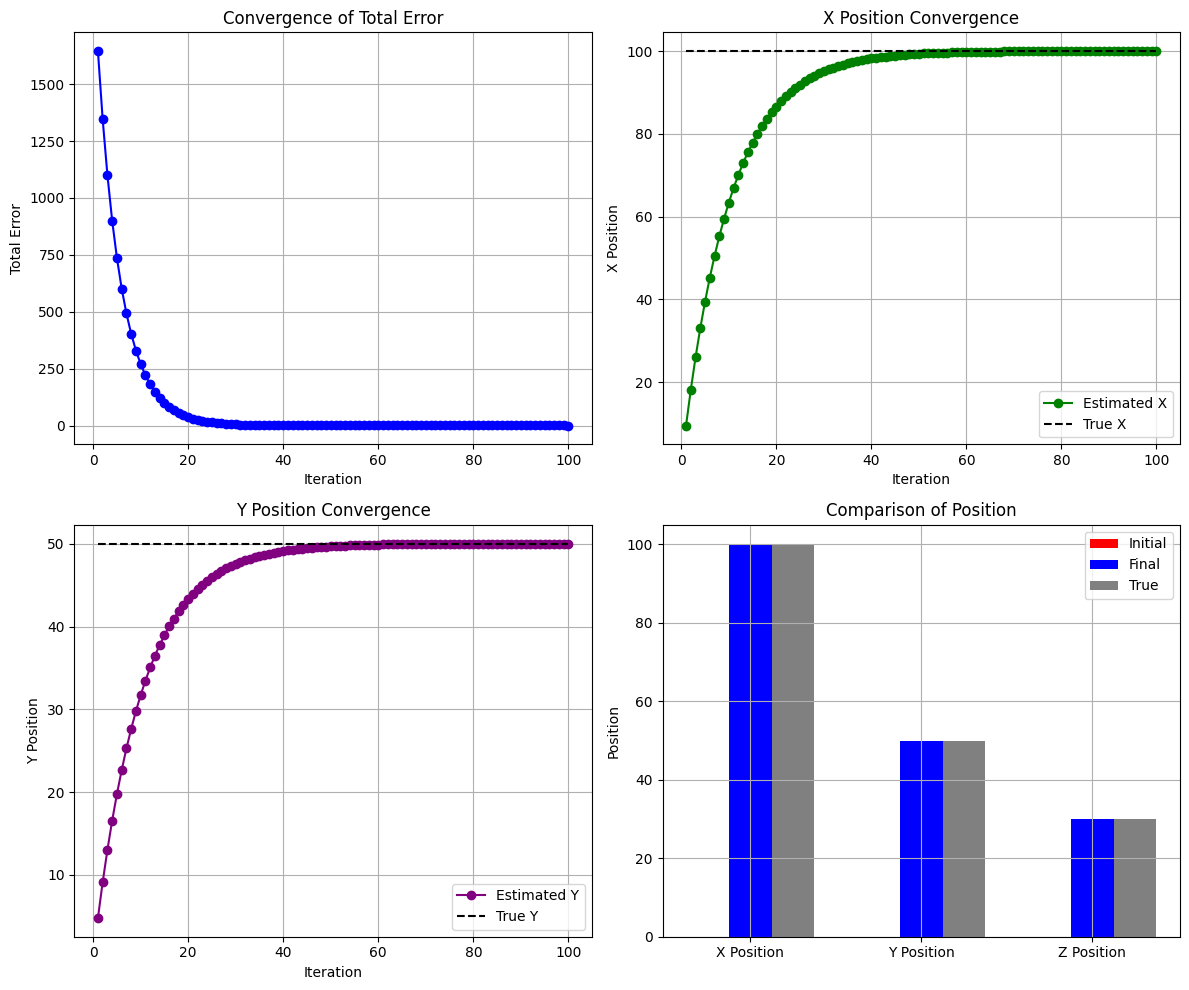

In [2]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot convergence of the total error.
axs[0, 0].plot(np.arange(1, n_iterations + 1), error_history, marker='o', color='blue')
axs[0, 0].set_xlabel('Iteration')
axs[0, 0].set_ylabel('Total Error')
axs[0, 0].set_title('Convergence of Total Error')
axs[0, 0].grid(True)

# Plot evolution of the X position estimate.
axs[0, 1].plot(np.arange(1, n_iterations + 1), state_history[:, 0], marker='o', color='green', label='Estimated X')
axs[0, 1].hlines(true_position[0], 1, n_iterations, colors='black', linestyles='dashed', label='True X')
axs[0, 1].set_xlabel('Iteration')
axs[0, 1].set_ylabel('X Position')
axs[0, 1].set_title('X Position Convergence')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot evolution of the Y position estimate.
axs[1, 0].plot(np.arange(1, n_iterations + 1), state_history[:, 1], marker='o', color='purple', label='Estimated Y')
axs[1, 0].hlines(true_position[1], 1, n_iterations, colors='black', linestyles='dashed', label='True Y')
axs[1, 0].set_xlabel('Iteration')
axs[1, 0].set_ylabel('Y Position')
axs[1, 0].set_title('Y Position Convergence')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Bar chart comparing initial, final, and true states for all position components.
labels = ['X Position', 'Y Position', 'Z Position']
initial_vals = [initial_state[0], initial_state[1], initial_state[2]]
final_vals = [final_state[0], final_state[1], final_state[2]]
true_vals = [true_position[0], true_position[1], true_position[2]]

x = np.arange(len(labels))  # label locations
width = 0.25  # width of the bars

axs[1, 1].bar(x - width, initial_vals, width, label='Initial', color='red')
axs[1, 1].bar(x, final_vals, width, label='Final', color='blue')
axs[1, 1].bar(x + width, true_vals, width, label='True', color='gray')
axs[1, 1].set_xticks(x)
axs[1, 1].set_xticklabels(labels)
axs[1, 1].set_ylabel('Position')
axs[1, 1].set_title('Comparison of Position')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


### Workflow for a C++ Application with a Python Interface

1. **Develop and Test the C++ Library:**  
   - Write and compile your C++ code (classes, main application, tests).
   - Ensure your library works as intended using C++ tests or a simple executable.

2. **Write the pybind11 Wrapper:**  
   - Create a new C++ file (e.g., `pyabofgo.cpp`) that includes pybind11 headers.
   - Expose the functions and classes that should be available to Python.
   - Use lambda functions or direct method bindings to handle pointer management and conversions.

3. **Configure CMake to Build Both the C++ Executable and the Python Module:**  
   - Use `pybind11_add_module` for the Python module.
   - Link your library with the Python module target.
   - Ensure proper include directories and dependency linkage.

4. **Build the Project:**  
   - Configure with CMake, compile the code, and test both the C++ executable and the Python module.
   - Use a virtual environment or system Python to import and test the module.

---